# Processing of GDP sub set before applying the methodology

## Import libraries

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import cartopy.crs                     as ccrs

from pyproj import Geod
g = Geod(ellps='WGS84')

### Plotting functions

In [2]:
from plot_functions import createFigurewithProjection, shapeAxis

## Import GDP drifter trajectories and bathymetry data 

In [3]:
gdp_ds = pd.read_csv('../data/GDP/interpolated_gld.20221202_104507')

bathy = xr.open_dataset('../data/bathy/GEBCO_02_Dec_2022_8bb5cd71a07e/gebco_2022_n62.0_s59.0_w-49.0_e-40.0.nc')

In [4]:
id_drift= np.array([gdp_ds.iloc[i].values[0].split()[0] for i in range(len(gdp_ds))], dtype=int)
time = np.array([gdp_ds.iloc[i].values[0].split()[1]+'T'+gdp_ds.iloc[i].values[0].split()[2] for i in range(len(gdp_ds))], dtype=np.datetime64)
speed = np.array([gdp_ds.iloc[i].values[0].split()[8] for i in range(len(gdp_ds))], dtype=float)
lon = np.array([gdp_ds.iloc[i].values[0].split()[4] for i in range(len(gdp_ds))], dtype=float)
lat = np.array([gdp_ds.iloc[i].values[0].split()[3] for i in range(len(gdp_ds))], dtype=float)

u = np.array([gdp_ds.iloc[i].values[0].split()[6] for i in range(len(gdp_ds))], dtype=float)/100 # m/s
v = np.array([gdp_ds.iloc[i].values[0].split()[7] for i in range(len(gdp_ds))], dtype=float)/100 # m/s

## Data investigation

In [5]:
print('Total number of drifters available: ' +str(len(np.unique(id_drift))))

Total number of drifters available: 313


Text(0.5, 0, 'Time')

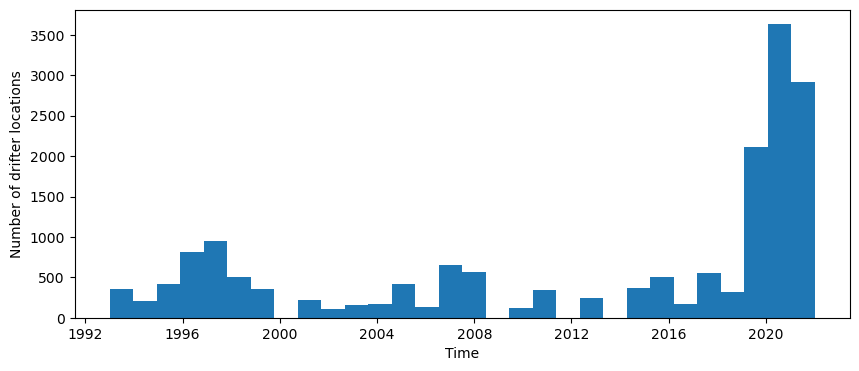

In [6]:
plt.figure(figsize=(10,4))
__ = plt.hist(time, bins=30)
plt.ylabel('Number of drifter locations')
plt.xlabel('Time')

In [7]:
start_time = np.array([time[id_drift == np.unique(id_drift)[i]][0] for i in range(len(np.unique(id_drift)))])
start_lon = np.array([lon[id_drift == np.unique(id_drift)[i]][0] for i in range(len(np.unique(id_drift)))])
start_lat = np.array([lat[id_drift == np.unique(id_drift)[i]][0] for i in range(len(np.unique(id_drift)))])

We only select trajectories starting on the shelf (our area of investigation). Some trajectories started on the East Greenland Shelf around 60.5°-61°N. These trajectories correspond to the drifters studied in the main part of the article. We do not want to include these trajectories here, because this large number of drifters deployed at the same time will influence the result. Indeed, apart from these, the number of buoys traveling between 1993 and 2021 is relatively small.

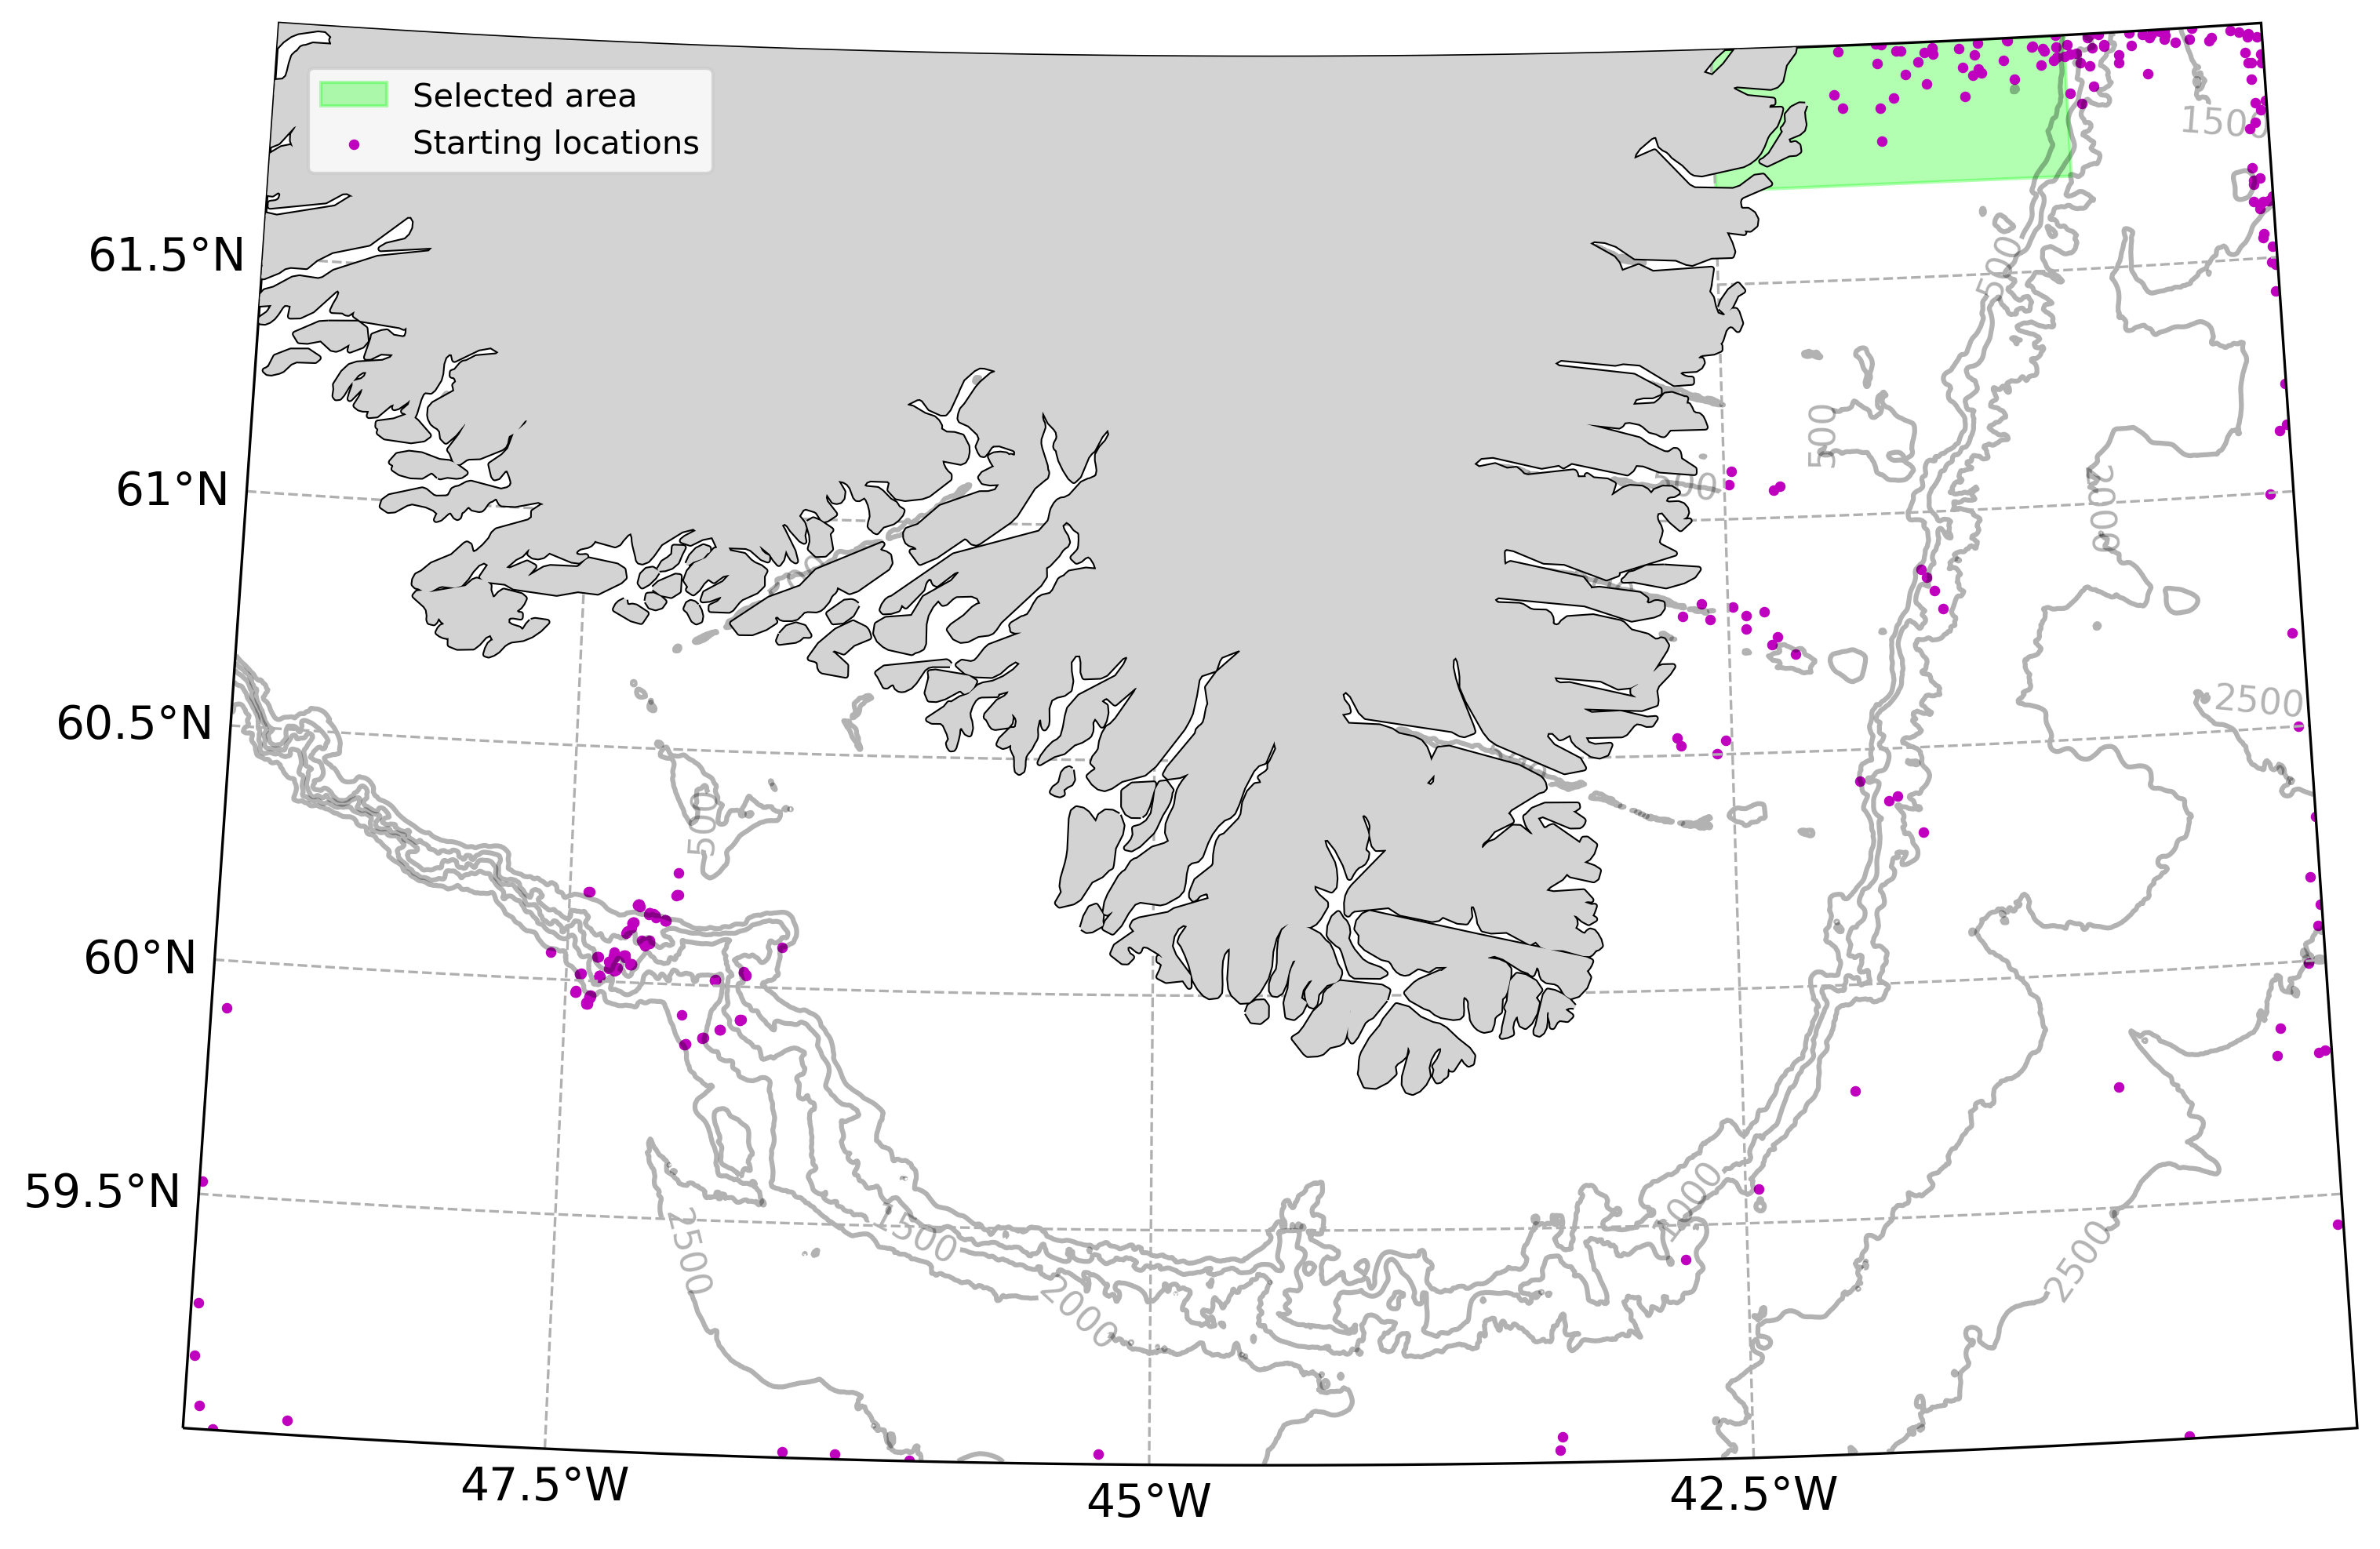

In [8]:
fig, ax, rect = createFigurewithProjection(figsize=(10, 10), nrows=1, ncols=1, bounds=[-49, -40, 59, 62])

shapeAxis(ax, rect, addCoastline=True)

CS = (-1*bathy.elevation).plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='k', alpha=0.3, levels=np.arange(500, 3000, 500))
ax.clabel(CS, CS.levels, inline=True, fontsize=11, zorder=1)

ax.fill_between([-42.5, -40.9], 61.7, 62, transform=ccrs.PlateCarree(), alpha=0.3, color='lime', label='Selected area')

ax.scatter(start_lon, start_lat, s=5, marker='o', c='m', transform=ccrs.PlateCarree(), label='Starting locations')

ax.legend(loc='upper left', bbox_to_anchor=(0.05, 0.98))

In [9]:
good_ids = np.unique(id_drift)[(start_lon>-42.5)&(start_lon<-40.9)&(start_lat>61.7)]
len(good_ids)

39

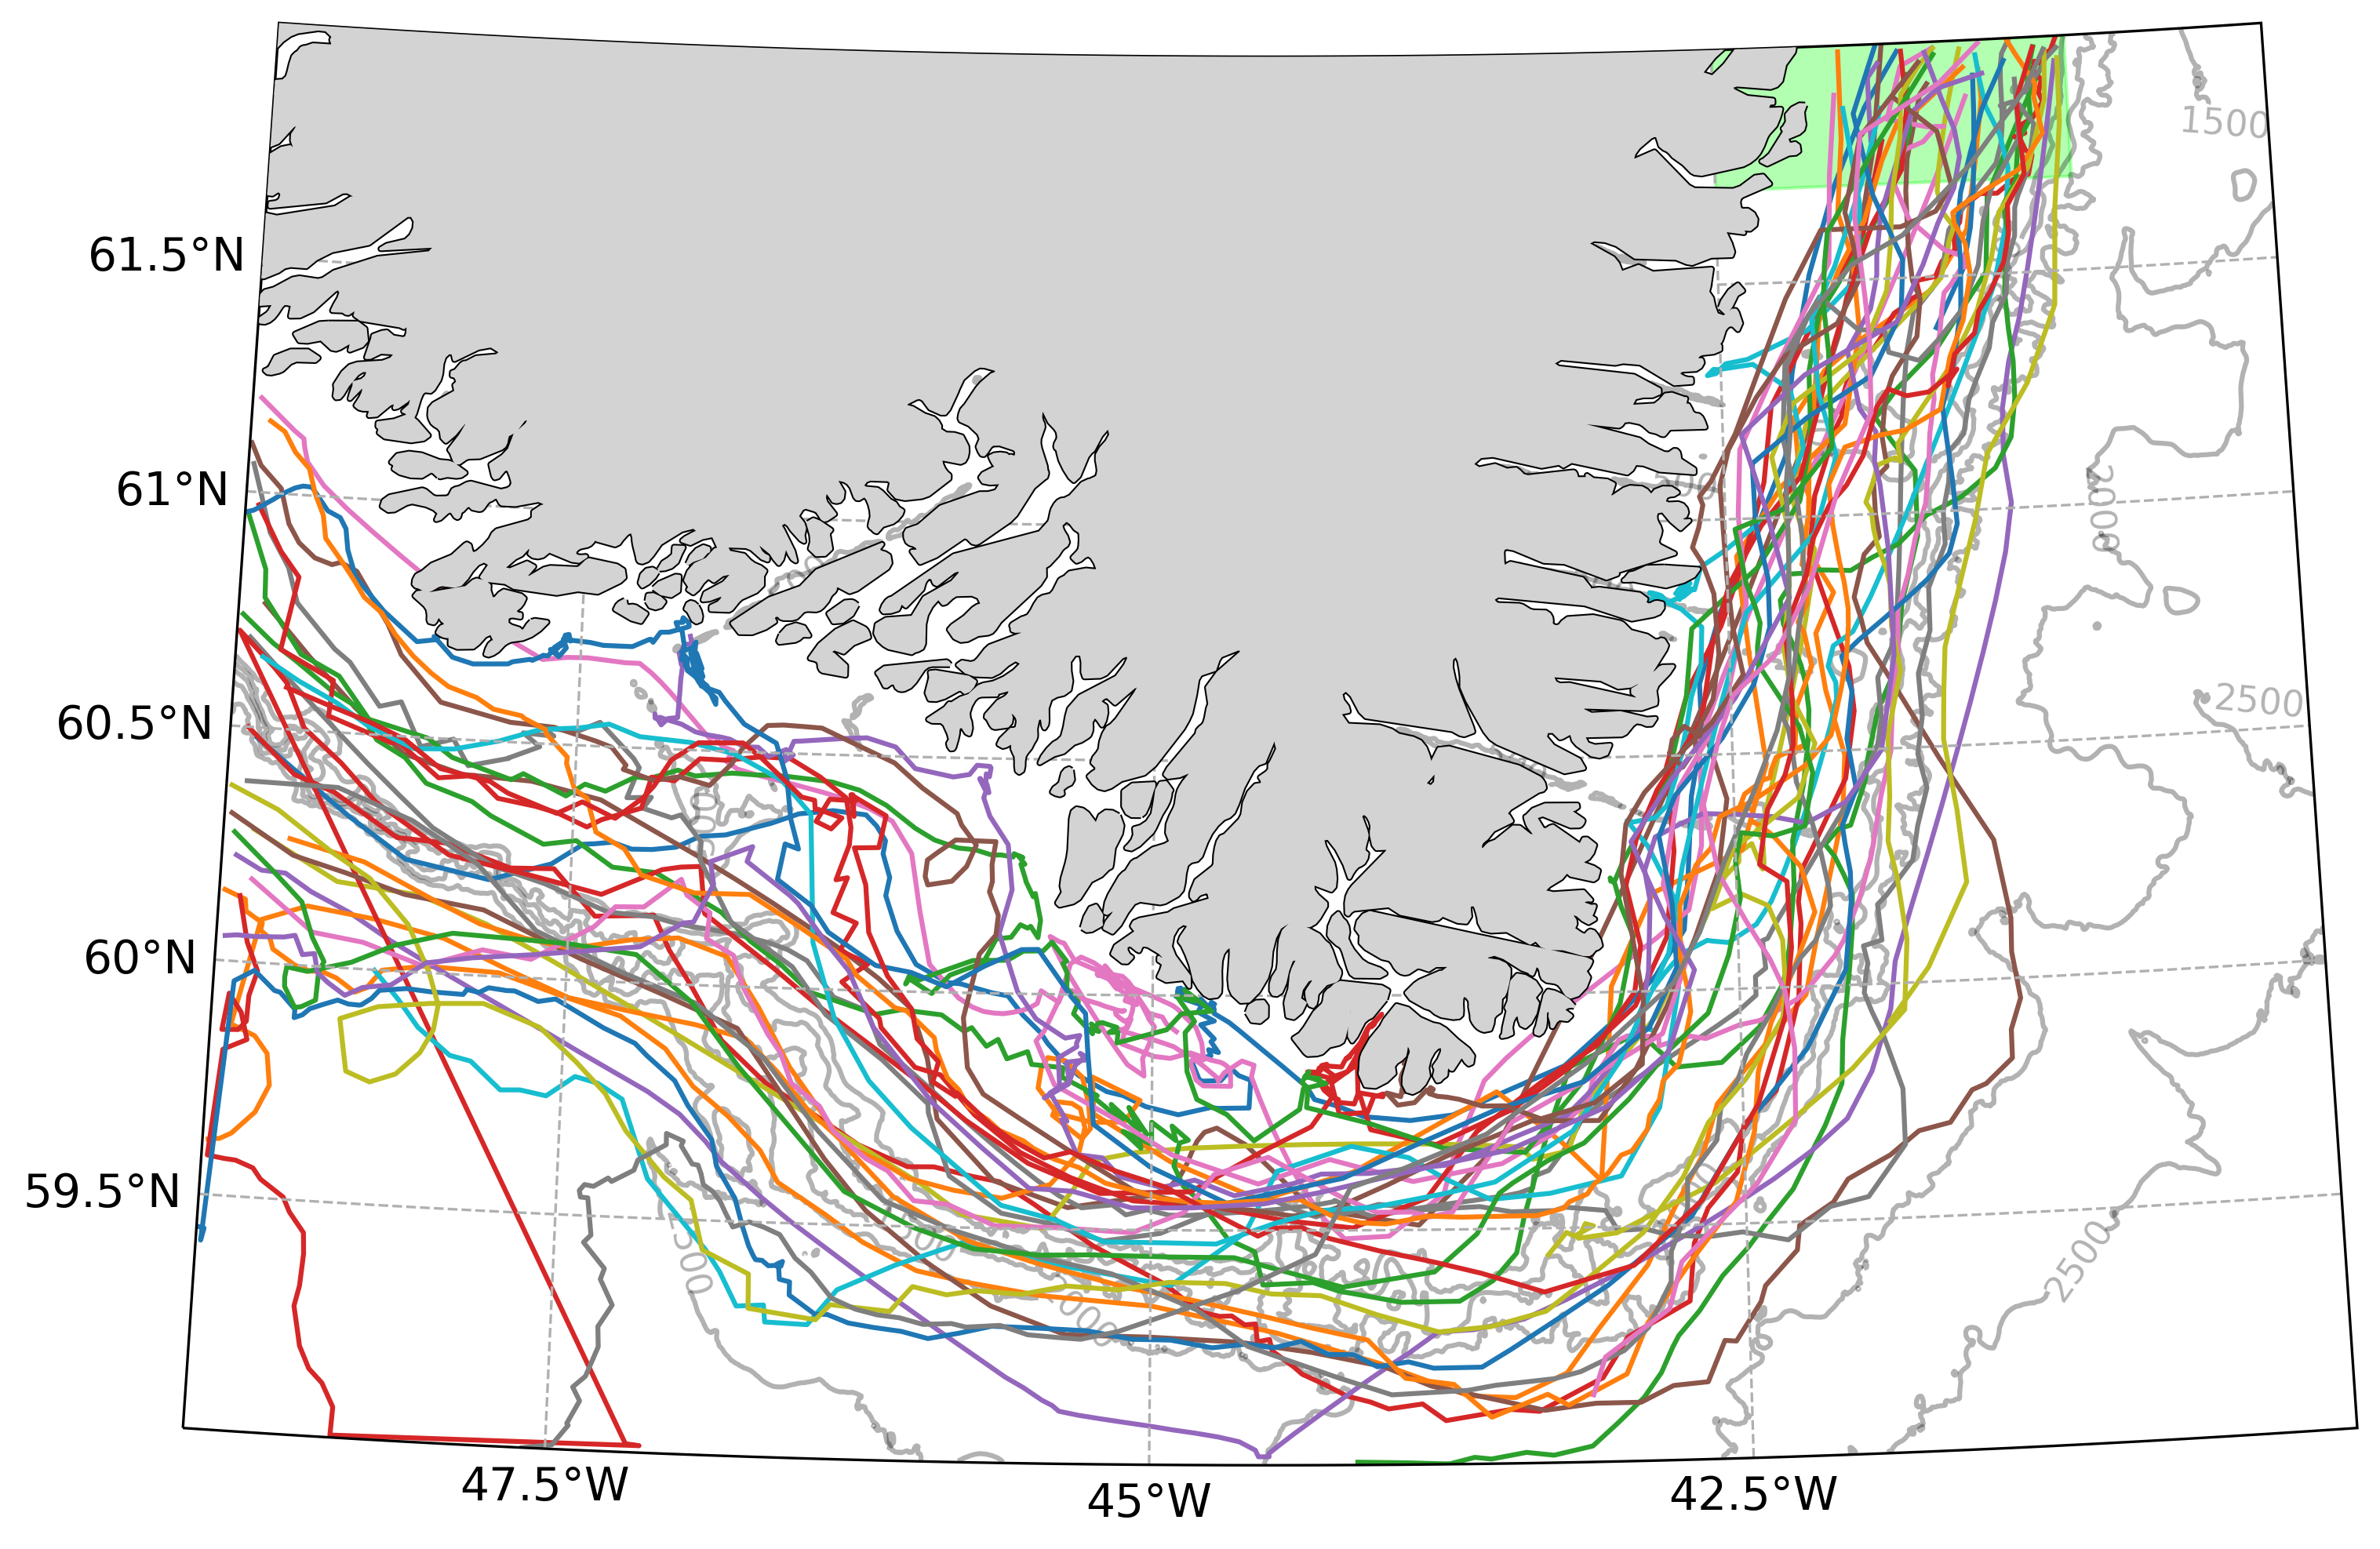

In [10]:
fig, ax, rect = createFigurewithProjection(figsize=(10, 10), nrows=1, ncols=1, bounds=[-49, -40, 59, 62])

shapeAxis(ax, rect, addCoastline=True)

CS = (-1*bathy.elevation).plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='k', alpha=0.3, levels=np.arange(500, 3000, 500))
ax.clabel(CS, CS.levels, inline=True, fontsize=11, zorder=1)

ax.fill_between([-42.5, -40.9], 61.7, 62, transform=ccrs.PlateCarree(), alpha=0.3, color='lime')

for i in range(len(good_ids)):
    ax.plot(lon[id_drift==good_ids[i]], lat[id_drift==good_ids[i]], transform=ccrs.PlateCarree(), label=good_ids[i])

We also check that the trajectories are complete and not cut. In case of cut, we select only the first part. Trajectories in August and September are also rejected to investigate the consistency for the months not sampled by the drifters we deployed.

In [11]:
ID_temp, LON_temp, LAT_temp, TIME_temp, U_temp, V_temp = [], [], [], [], [], []

for i in range(len(good_ids)):
    
    # Keep only continuous data
    if any(np.diff(time[id_drift==good_ids[i]]) != np.timedelta64(21600)):
        stop = np.where(np.diff(time[id_drift==good_ids[i]]) != np.timedelta64(21600))[0][0]
    else: 
        stop = len(time[id_drift==good_ids[i]])

    # Check no data come from August or September
    if all(pd.to_datetime(time[id_drift==good_ids[i]]).month != 8) or all(pd.to_datetime(time[id_drift==good_ids[i]]).month != 9):

        ID_temp.append(id_drift[id_drift==good_ids[i]][:stop])
        LON_temp.append(lon[id_drift==good_ids[i]][:stop])
        LAT_temp.append(lat[id_drift==good_ids[i]][:stop])
        TIME_temp.append(time[id_drift==good_ids[i]][:stop])
        U_temp.append(u[id_drift==good_ids[i]][:stop])
        V_temp.append(v[id_drift==good_ids[i]][:stop])


In [12]:
print('Number of drifters conserved: '+str(len(ID_temp)))

Number of drifters conserved: 35


## Create the final/processed data set

Finally, we build matrices to store the data in a xarray Dataset and a netcdf file.

In [13]:
LON = np.zeros((len(ID_temp), np.max([len(TIME_temp[i]) for i in range(len(TIME_temp))])))*np.nan
LAT = np.zeros((len(ID_temp), np.max([len(TIME_temp[i]) for i in range(len(TIME_temp))])))*np.nan
TIME = np.zeros((len(ID_temp), np.max([len(TIME_temp[i]) for i in range(len(TIME_temp))])), dtype='datetime64[s]')
U = np.zeros((len(ID_temp), np.max([len(TIME_temp[i]) for i in range(len(TIME_temp))])))*np.nan
V = np.zeros((len(ID_temp), np.max([len(TIME_temp[i]) for i in range(len(TIME_temp))])))*np.nan

for i in range(len(ID_temp)):
    LON[i, :len(TIME_temp[i])] = LON_temp[i]
    LAT[i, :len(TIME_temp[i])] = LAT_temp[i]
    TIME[i, :len(TIME_temp[i])] = TIME_temp[i]
    U[i, :len(TIME_temp[i])] = U_temp[i]
    V[i, :len(TIME_temp[i])] = V_temp[i]

In [14]:
ds = xr.Dataset(
    data_vars=dict(
        lon=(["traj", "obs"], LON),
        lat=(["traj", "obs"], LAT),
        u=(["traj", "obs"], U),
        v=(["traj", "obs"], V),
        time=(["traj", "obs"], TIME),
    ),
    coords=dict(
        drifter_id=(["traj"], np.array([ID_temp[i][0] for i in range(len(ID_temp))])),
        obs=(["obs"], np.arange(len(LON[0]))),
   ),
    attrs=dict(description="Processed GDP trajectories."),
)

In [15]:
ds

<xarray.Dataset>
Dimensions:     (traj: 35, obs: 232)
Coordinates:
    drifter_id  (traj) int64 21086 21628 ... 300534060386920 300534061175480
  * obs         (obs) int64 0 1 2 3 4 5 6 7 ... 224 225 226 227 228 229 230 231
Dimensions without coordinates: traj
Data variables:
    lon         (traj, obs) float64 -41.66 -41.82 -41.97 -42.09 ... nan nan nan
    lat         (traj, obs) float64 61.98 61.87 61.7 61.51 ... nan nan nan nan
    u           (traj, obs) float64 -0.08174 -0.3739 -0.3421 ... nan nan nan
    v           (traj, obs) float64 -0.638 -0.7256 -0.9071 ... nan nan nan
    time        (traj, obs) datetime64[ns] 2004-09-06T18:00:00 ... 1970-01-01
Attributes:
    description:  Processed GDP trajectories.

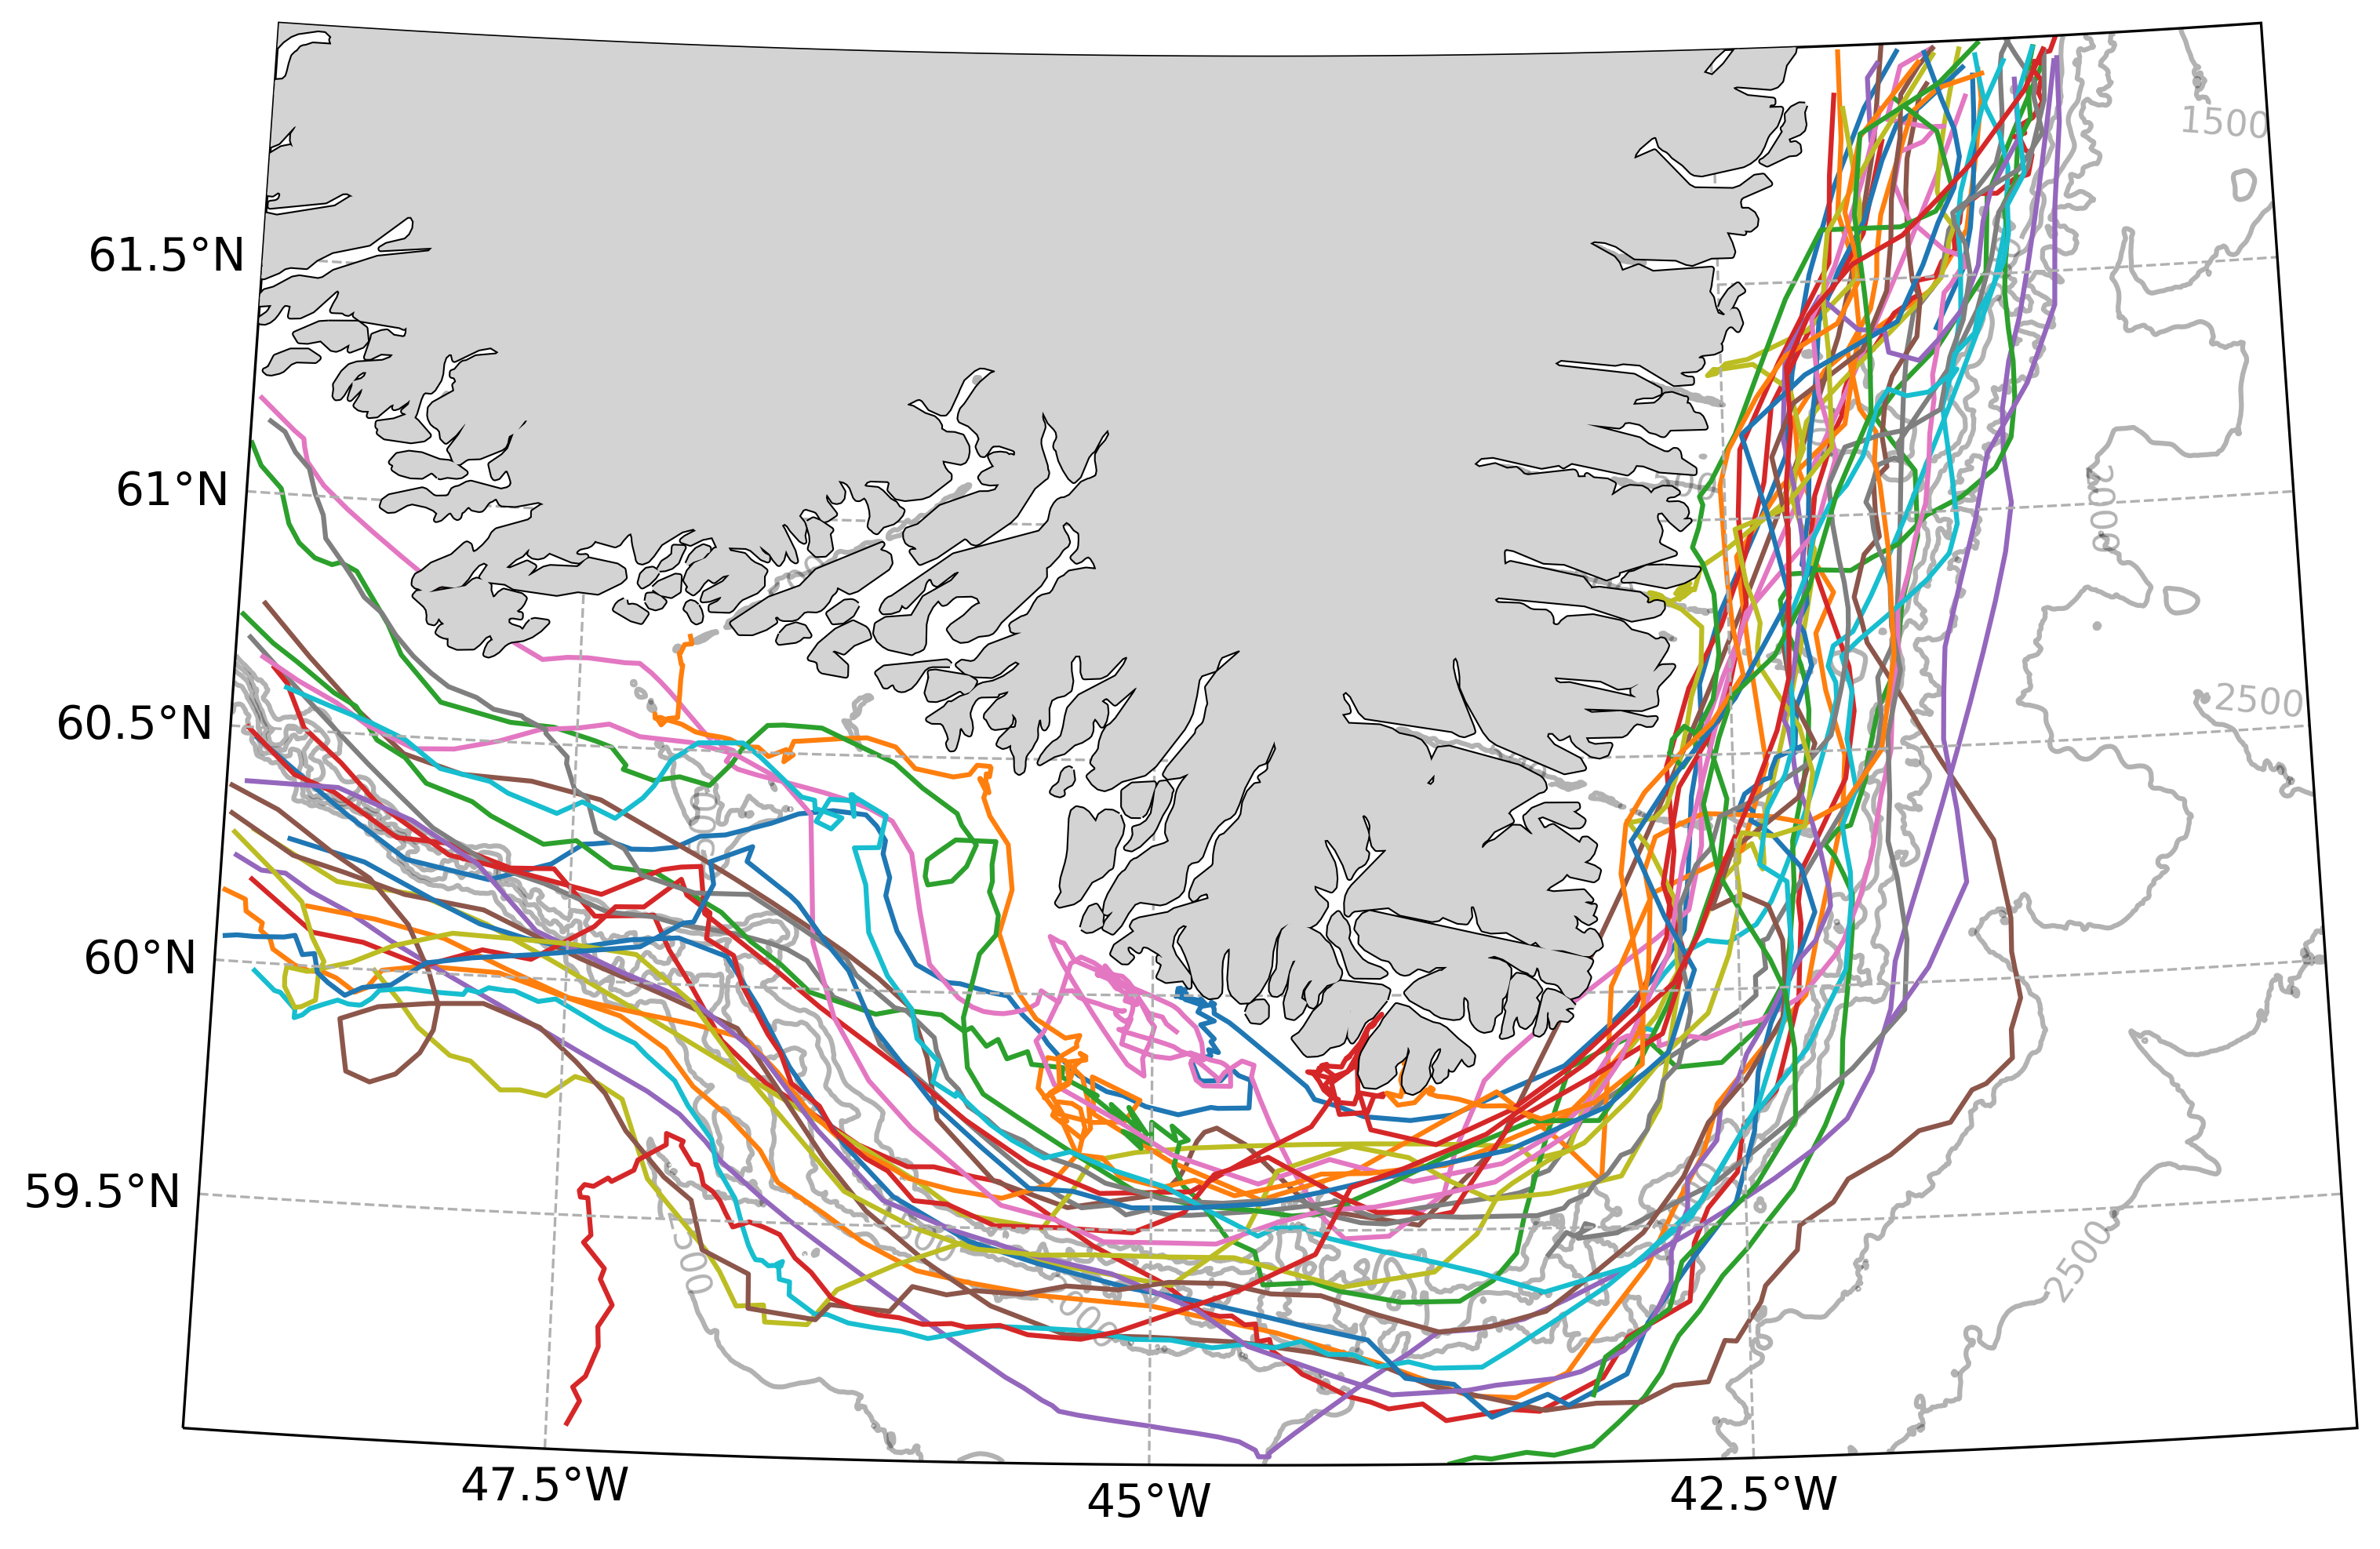

In [16]:
fig, ax, rect = createFigurewithProjection(figsize=(10, 10), nrows=1, ncols=1, bounds=[-49, -40, 59, 62])

shapeAxis(ax, rect, addCoastline=True)

CS = (-1*bathy.elevation).plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='k', alpha=0.3, levels=np.arange(500, 3000, 500))
ax.clabel(CS, CS.levels, inline=True, fontsize=11, zorder=1)

for i in range(len(ds.traj)):
    ax.plot(ds.isel(traj=i).lon, ds.isel(traj=i).lat, transform=ccrs.PlateCarree(), label=ds.isel(traj=i).drifter_id)

In [17]:
# ds.to_netcdf('../data/GDP/processed_gdp_data.nc')